NanoVLM: tiny CLIP-style model trained on synthetic colored-shaped captions.

For a given text caption, we have to retrieve the best images from the dataset.

This is a tiny CLIP-styled Vision language Model. It has 2 separate encoders- one for images and one for text. Both encoder map their inputs into a common embeddingspace of dimension 64 (or other dimension we choose). THe goal is to make matching image-text pairs lie close together in this space.

Image Encoder

- A small CNN (4 convolutional layers) progressively downsamples the input image.
- After the convolution blocks, a global average pooling layer reduces spatial features.
- A linear projection maps to the embedding dimension.
- Finally, a LayerNorm + L2 normalization ensures ambeddings are unit vectors (important for cosine similarity).

Text Encoder

- Each caption has tokens like [CLS] red triangle left.
- A token embedding layer converts each word to a 64-D vector.
- A positional embedding layer adds position info (like transformer).
- MHA after this.
- Followed by a linear layer + LayerNorm + L2 normalization.

IMPORTS

In [1]:
import numpy as np
import math, random
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

d:\Virtual Environments\PyTorch\venv\Lib\site-packages\torch\cuda\__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


VARIABLES

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMG_SIZE = 32
EMBED_DIM = 64
ATTENTION_HEADS = 4
BATCH_SIZE = 12
EPOCHS = 10
LR = 3e-4
TEMPERATURE = 0.07

SYNTHETIC DATASET PROPERTIES

In [3]:
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'pink', 'brown', 'gray']
shapes = ['square', 'circle', 'triangle']
positions = ['left', 'center', 'right', 'top', 'bottom', 'top-left', 'top-right', 'bottom-left', 'bottom-right']

DRAWING IMAGE SHAPES

In [4]:
def draw_sample(color, shape, position, img_size = IMG_SIZE):
    img = Image.new('RGB', (img_size, img_size), 'white')
    draw = ImageDraw.Draw(img)
    margin = 6
    w = h = img_size - 2*margin
    # Calculate x coordinates
    if 'left' in position:
        x0 = margin
        x1 = margin + w // 2
    elif 'top-left' in position:
        x0 = margin
        x1 = margin + w // 2
    elif 'bottom-left' in position:
        x0 = margin
        x1 = margin + w // 2
    elif 'right' in position:
        x0 = margin + w // 2
        x1 = img_size - margin
    elif 'top-right' in position:
        x0 = margin + w // 2
        x1 = img_size - margin
    elif 'bottom-right' in position:
        x0 = margin + w // 2
        x1 = img_size - margin
    else:   # Center or vertical positions
        x0 = margin + w // 4
        x1 = margin + 3 * w // 4
    # Calculate y coordinates
    if 'top' in position:
        y0 = margin
        y1 = margin + h // 2
    elif 'top-left' in position:
        y0 = margin
        y1 = margin + h // 2
    elif 'top-right' in position:
        y0 = margin
        y1 = margin + h // 2
    elif 'bottom' in position:
        y0 = margin + h // 2
        y1 = img_size - margin
    elif 'bottom-left' in position:
        y0 = margin + h // 2
        y1 = img_size - margin
    elif 'bottom-right' in position:
        y0 = margin + h // 2
        y1 = img_size - margin
    else:   # Center or horizontal positions
        y0 = margin + h // 4
        y1 = margin + 3 * h // 4
    
    if shape == 'square':
        draw.rectangle([x0, y0, x1, y1], fill=color, outline='black')
    elif shape == 'circle':
        draw.ellipse([x0, y0, x1, y1], fill=color, outline='black')
    else:   # Triangle
        draw.polygon([(x0+(x1-x0)//2, y0), (x0, y1), (x1, y1)], fill=color, outline='black')
    return img

CLASS FOR BUILDING DATASET

In [5]:
class ShapesDataset():
    def __init__(self):
        self.images = []
        self.captions = []

        for c in colors:
            for s in shapes:
                for p in positions:
                    img = draw_sample(c, s, p)
                    cap = f"{c} {s} {p}"
                    
                    self.images.append(torch.from_numpy(np.asarray(img)).permute(2, 0, 1).float()/255.0)
                    self.captions.append(cap)
        
        self.vocab, self.word2idx = self.build_vocab(self.captions)

    def build_vocab(self, texts):
        words = sorted({w for t in texts for w in t.split()})
        vocab = ['[CLS]'] + words
        w2i = {w:i for i, w in enumerate(vocab)}
        return vocab, w2i
    
    def encode_text(self, text):
        toks = [self.word2idx['[CLS]']] + [self.word2idx[w] for w in text.split()]
        return torch.tensor(toks, dtype=torch.long)
    
    def __getitem__(self, idx):
        return self.images[idx], self.encode_text(self.captions[idx])
    
    def __len__(self):  return len(self.images)

CREATE FULL DATASET

In [6]:
full_ds = ShapesDataset()
VOCAB_SIZE = len(full_ds.vocab)
print(VOCAB_SIZE)
print(full_ds.vocab)

22
['[CLS]', 'blue', 'bottom', 'bottom-left', 'bottom-right', 'brown', 'center', 'circle', 'gray', 'green', 'left', 'orange', 'pink', 'purple', 'red', 'right', 'square', 'top', 'top-left', 'top-right', 'triangle', 'yellow']


C:\Users\dhruv\AppData\Local\Temp\ipykernel_18540\3120046610.py:12: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:209.)
  self.images.append(torch.from_numpy(np.asarray(img)).permute(2, 0, 1).float()/255.0)


TRAIN-VAL SPLITTING

In [7]:
train_size = int(0.8*len(full_ds))
val_size = len(full_ds) - train_size
train_ds, val_ds = torch.utils.data.random_split(full_ds, [train_size, val_size])

DATALOADER

In [8]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

DISPLAY A SAMPLE DATA POINT

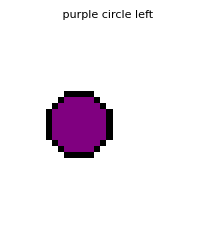

In [9]:
imgs, encoded_caps = next(iter(train_loader))
idx = random.randint(0, len(imgs)-1)
img = (imgs[idx].permute(1, 2, 0).numpy()*255).astype(np.uint8) # Convert to displayable image

# Decode the caption
caption_tokens = encoded_caps[idx].tolist()
caption = " ".join([full_ds.vocab[token] for token in caption_tokens if token in range(len(full_ds.vocab))])

# Remove the [CLS] token from the displayed caption
caption = caption.replace('[CLS]', '')

plt.figure(figsize=(2.5, 2.5))
plt.imshow(img)
plt.title(caption, fontsize = 8)
plt.axis('off')
plt.show()

IMAGE ENCODER

In [10]:
class ImageEncoder(nn.Module):
    def __init__(self, embed_dim = EMBED_DIM):
        super().__init__()
        self.convolutions = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.ReLU()
        )
        self.projection = nn.Linear(256, embed_dim)
        self.layernorm1 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.convolutions(x)
        x = x.mean(dim=[2, 3])
        x = self.projection(x)
        x = F.normalize(self.layernorm1(x), dim=-1)
        return x

TEXT ENCODER

In [11]:
class TextEncoder(nn.Module):
    def __init__(self, embed_dim = EMBED_DIM, num_heads = ATTENTION_HEADS, vocab_size = VOCAB_SIZE, context_window = 4):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(context_window, embed_dim)
        self.mha = nn.MultiheadAttention(embed_dim, num_heads)
        self.projection = nn.Linear(embed_dim, embed_dim)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, toks):
        N, L = toks.shape
        position_embedding_ids = torch.arange(L, device = toks.device).unsqueeze(0).expand(N, L)
        position_embedding_vectors = self.position_embedding(position_embedding_ids)
        token_embedding_vectors = self.token_embedding(toks)
        x = token_embedding_vectors + position_embedding_vectors
        x = self.mha(x, x, x)[0]
        x = x[:,0]
        x = self.projection(x)
        x = F.normalize(self.norm(x), dim=-1)
        return x

CLIP LOSS

In [12]:
def clip_loss(img_emb, text_emb, temperature = TEMPERATURE):
    logits = img_emb @ text_emb.T / temperature
    targets = torch.arange(img_emb.size(0), device=img_emb.device)
    loss_i = F.cross_entropy(logits, targets)
    loss_t = F.cross_entropy(logits.T, targets)
    return ((loss_i + loss_t) / 2.0)

MODEL, DATA, OPTIMIZER

In [13]:
img_enc = ImageEncoder().to(device)
txt_enc = TextEncoder().to(device)
params = list(img_enc.parameters()) + list(txt_enc.parameters())
optimizer = torch.optim.AdamW(params, lr = LR)

In [14]:
def show_image(t, title=None):
    img = (t.permute(1,2,0).numpy()*255).astype(np.uint8)
    plt.figure(figsize=(2.2,2.2))
    plt.axis('off')
    if title: plt.title(title, fontsize=8)
    plt.imshow(img); plt.show()

In [ ]:
# img_enc.eval(); txt_enc.eval()
# with torch.no_grad():
#     # Select a random index
#     random_idx= random.randrange(len(full_ds))
#     sample_img, sample_toks, sample_cap = full_ds[random_idx]
#     sample_img = sample_img.unsqueeze().to(device)
#     pre_train_img_emb = img_enc(sample_img).squeeze().cpu().numpy()
#     pre_train_txt_emb = txt_enc(sample_toks).squeeze().cpu().numpy()
#     sample_toks = sample_toks.unsqueeze().to(device)
    
# # Display the sample image and caption
# print(f"Sample image and caption for embeddings visualization: {sample_cap}")
# show_image(sample_img.squeeze().cpu())
# # Function to visualize embeddings (simplified)
# def plot_embedding(embedding, title):
#     plt.figure(figsize=(8, 1))
#     plt.imshow(embedding.reshape(1, -1), aspect = 'auto', cmap='viridis')
#     plt.title(title)
#     plt.axis('off')
#     plt.show()

# plot_embedding(pre_train_img_emb, "Pre-Training Image Embedding")

# plot_embedding(pre_train_txt_emb, "Pre-Training Text Embedding")

ValueError: not enough values to unpack (expected 3, got 2)